In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [4]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 5],
    2: [4, 1],
    3: [2, 3]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

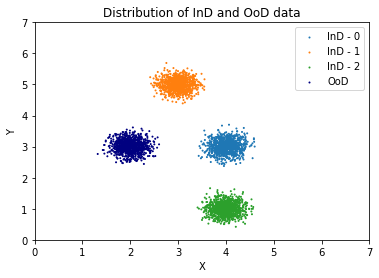

In [5]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

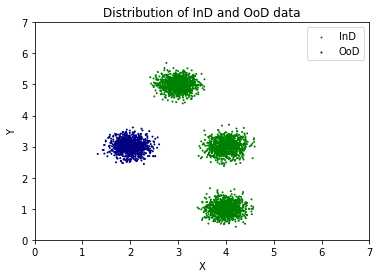

In [6]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [7]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
# D = DSIM()
D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  2%|▏         | 4/256 [00:00<00:14, 17.14it/s]

Epoch  # 1 | Tri loss: 1.7842                     | Tri accuracy: 0.3327
Epoch  # 1 | Val loss: 1.6776                     | Val accuracy: 0.3338


 21%|██        | 53/256 [00:02<00:10, 19.38it/s]

Epoch  # 51 | Tri loss: 0.2638                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.2582                     | Val accuracy: 1.0


 40%|███▉      | 102/256 [00:04<00:08, 18.59it/s]

Epoch  # 101 | Tri loss: 0.062                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0615                     | Val accuracy: 1.0


 61%|██████    | 155/256 [00:07<00:04, 23.77it/s]

Epoch  # 151 | Tri loss: 0.0238                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0238                     | Val accuracy: 1.0


 79%|███████▉  | 203/256 [00:09<00:02, 20.38it/s]

Epoch  # 201 | Tri loss: 0.0119                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.012                     | Val accuracy: 1.0


100%|█████████▉| 255/256 [00:11<00:00, 24.23it/s]

Epoch  # 251 | Tri loss: 0.0068                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0069                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:11<00:00, 21.35it/s]


#### Plot

torch.Size([10000, 3])


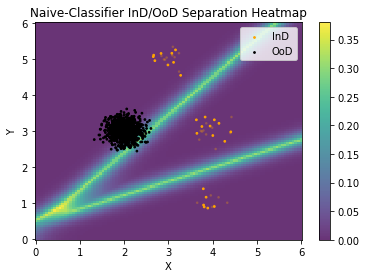

In [8]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [ ]:
from simulation import *
D_WOOD = DSIM(64)
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
n_ood = 4
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

In [31]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 1.0
0.999: 1.0


0.000418025565799335

### OOD GAN Training

In [ ]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64)
G_GAN = GSIM(64)
# D_GAN = DSIM_SINGLE(64)
# G_GAN = GSIM_SINGLE(64)
# OOD data preparation
n_ood = 8
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 1, 0.1
scaling = 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist, scaling,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

### Plot

In [ ]:
n_ind, n_ood = 25, 25
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)

#### Plot Naive Classifier

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D, "NAIVE", ind_idx, ood_idx, m=100)

#### Plot WOOD

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, "WOOD", ind_idx, ood_idx, m=100)

#### Plot GAN

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, "OOD-GAN", ind_idx, ood_idx, m=100)

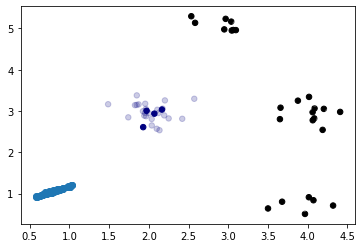

In [29]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')